In [276]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

In [277]:
cols = ['alcohol_by_weight', 'rating', 'bitterness', 'nitrogen', 'turbidity', 'sugars', 'degree_of_fermentation', 'calorific_value', 'density', 'pH', 'colour', 'sulphites']

In [278]:
cols_new = ['alcohol_by_weight', 'bitterness', 'nitrogen', 'turbidity', 'sugars', 'degree_of_fermentation', 'calorific_value', 'density', 'pH', 'colour', 'sulphites', 'rating']

In [309]:
df = pd.read_table("beer_ratings.txt")

In [310]:
df.columns = cols

In [311]:
df = df[cols_new]

In [312]:
df.describe()

,alcohol_by_weight,bitterness,nitrogen,turbidity,sugars,degree_of_fermentation,calorific_value,density,pH,colour,sulphites,rating
count,935.000000,935.000000,935.000000,935.000000,935.000000,935.000000,935.000000,935.000000,935.000000,935.000000,935.000000,935.000000
mean,4.964765,9.637005,0.629000,0.938655,16.306556,68.376073,18.365775,0.966953,3.803904,14.108829,13.987968,67.331551
std,0.521929,1.853187,0.187883,0.662576,8.469634,35.502363,10.125492,0.001938,0.157211,3.727295,10.246313,10.050473
min,4.000000,5.700000,0.220000,0.000000,7.560000,9.384000,4.000000,0.960640,3.240000,7.095000,1.875000,38.000000
25%,4.523810,8.300000,0.490000,0.332000,11.970000,55.522000,10.000000,0.965770,3.700000,11.825000,6.562500,60.000000
50%,4.809524,9.300000,0.620000,0.896400,13.860000,62.560000,16.000000,0.966930,3.800000,13.330000,11.250000,64.000000
75%,5.238095,10.700000,0.740000,1.494000,17.010000,71.944000,24.000000,0.968100,3.900000,15.802500,18.437500,74.000000
max,7.095238,17.000000,1.680000,3.320000,86.940000,477.020000,69.000000,0.973200,4.400000,43.000000,90.312500,94.000000


Now I need to split the data up into independent and dependent variables

In [313]:
scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns = cols_new)

In [314]:
X = df.iloc[:, :-1] # Independent Variables

In [315]:
y = df.iloc[:, -1] # Dependent Variables

In [316]:
y

0     -0.630313
1     -0.630313
2     -0.729864
3     -0.729864
4     -0.829415
         ...   
930    0.464749
931    0.663851
932    0.365198
933    0.564300
934    0.365198
Name: rating, Length: 935, dtype: float64

In [317]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

When running the model on every variable we have, it doesn't produce a good result so I need to limit them based on how good they correlate with rating scores

Text(0.5, 1.0, 'Correlation Matrix')

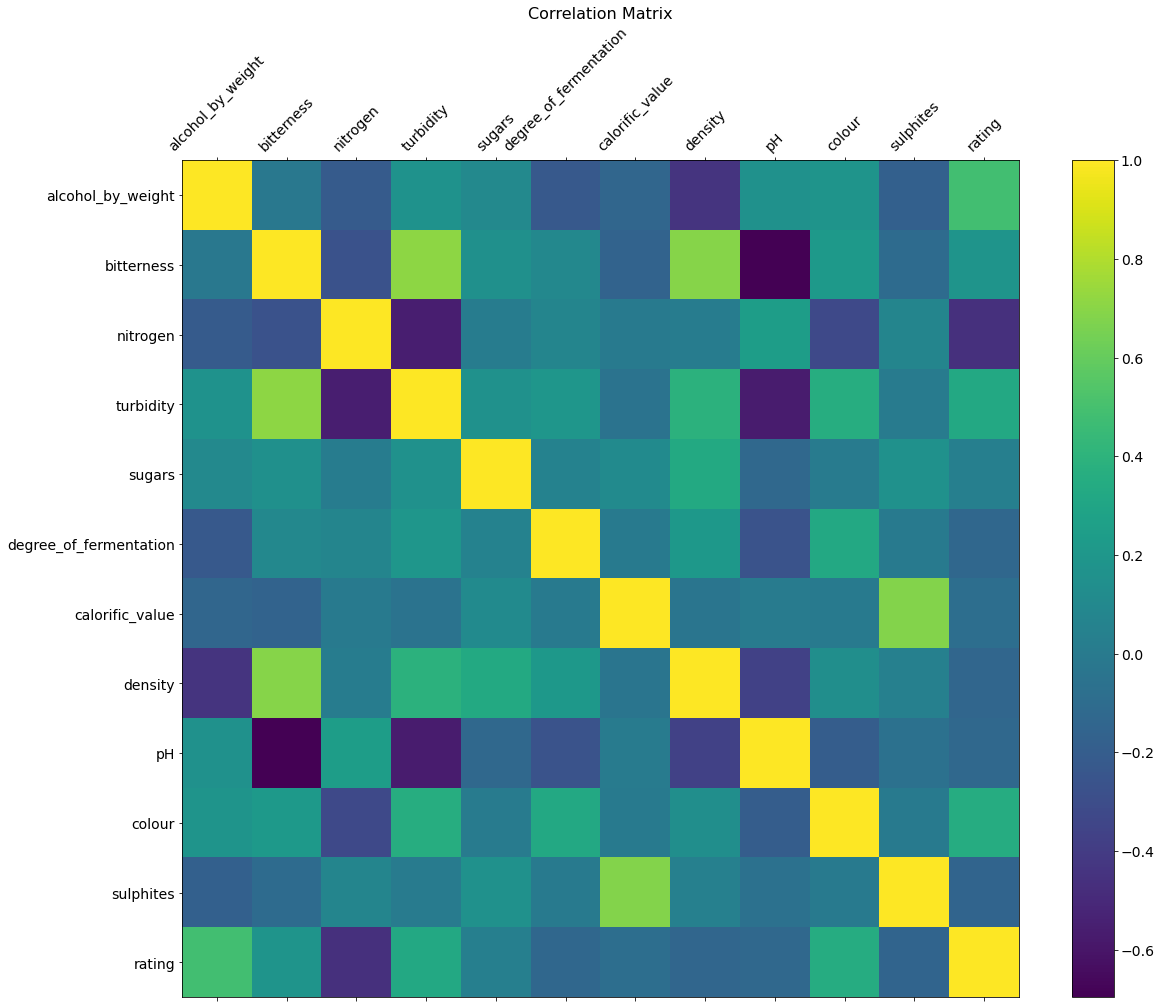

In [318]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum = f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize = 14, rotation = 45)
plt.yticks(range(df.shape[1]), df.columns, fontsize = 14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize = 14)
plt.title('Correlation Matrix', fontsize = 16)

I'm going to test it manually first by taking each variable and removing them one by one see which is doing the most damage, then I can remove again and again etc.

So what if we made a model with just these?

In [319]:
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                 rating   R-squared (uncentered):                   0.454
Model:                            OLS   Adj. R-squared (uncentered):              0.446
Method:                 Least Squares   F-statistic:                              55.82
Date:                Mon, 21 Dec 2020   Prob (F-statistic):                    2.12e-89
Time:                        00:12:29   Log-Likelihood:                         -831.79
No. Observations:                 748   AIC:                                      1686.
Df Residuals:                     737   BIC:                                      1736.
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

In [329]:
print('Parameters: ', results.params)
print()
print('R2: ', results.rsquared)

Parameters:  alcohol_by_weight         0.371211
bitterness                0.041399
nitrogen                 -0.247370
turbidity                 0.018176
sugars                    0.029011
degree_of_fermentation   -0.148138
calorific_value           0.019657
density                  -0.054949
pH                       -0.107735
colour                    0.218914
sulphites                -0.081096
dtype: float64

R2:  0.4544713096813694


In [330]:
predictions = results.predict(X_test)

In [331]:
prediction_error = y_test - predictions

#### Decision Tree

In [333]:
rt = DecisionTreeRegressor(max_depth = 11)
rt.fit(X_train, y_train)
y_pred = rt.predict(X_test) 

In [334]:
diff = y_test - y_pred

In [335]:
np.mean(diff)

-0.11142273754196685

In [336]:
rt.score(X_train, y_train)

0.9091556639761083

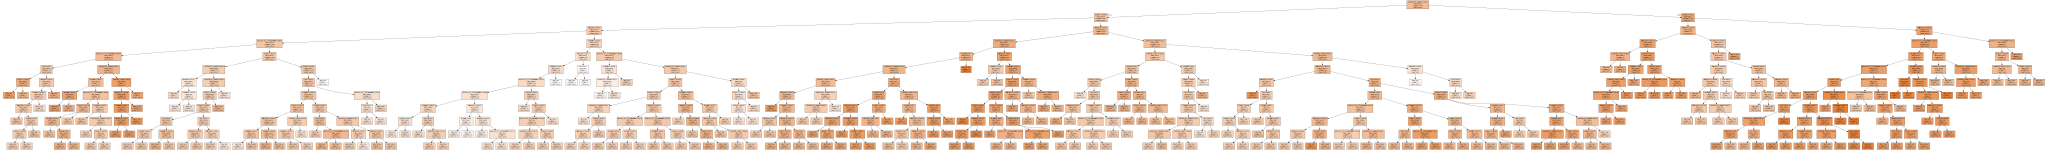

In [298]:
from sklearn import tree
import graphviz
dot_data = tree.export_graphviz(rt, feature_names=list(X), class_names=sorted(y.unique()), filled=True, out_file=None)
graphviz.Source(dot_data)

In [299]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))

Mean Absolute Error: 0.12649802007936303


In [300]:
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))

Mean Squared Error: 0.032476733391762616


In [301]:
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Root Mean Squared Error: 0.1802130222591104


In [302]:
print('R Squared Score is:', rt.score(X_train, y_train))

R Squared Score is: 0.9091556639761081


In [303]:
for importance, name in sorted(zip(rt.feature_importances_, X_train.columns),reverse = True):
    print (f'{name}:', f'{round(100 * importance, 2)}%')

alcohol_by_weight: 32.97%
colour: 18.78%
nitrogen: 14.98%
sulphites: 6.5%
degree_of_fermentation: 5.31%
turbidity: 4.84%
bitterness: 4.35%
calorific_value: 3.45%
pH: 3.38%
density: 3.15%
sugars: 2.3%


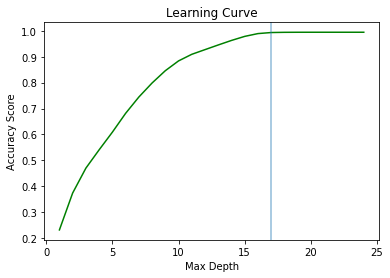

In [304]:
l = []
n = []
for i in range(1, 25):
    n.append(i)
    rt = DecisionTreeRegressor(max_depth = i)
    rt.fit(X_train, y_train)
    l.append(rt.score(X_train, y_train))
plt.plot(n, l, 'g-')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy Score')
plt.title('Learning Curve')
plt.axvline(x = 17, alpha = 0.5)
plt.show()

#### 

In [1]:
pass